In [1]:
import numpy as np
import os
import gin
from dopamine.agents.dqn import dqn_agent

# When using Gin interactively, reregistering a function is not an error.
gin.enter_interactive_mode()

/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [23]:
import gym, rec_gym
from rec_gym import env_1_args

@gin.configurable
def make_env():
    env = gym.make('prim-gym-v1')
    env.init_gym(env_1_args)
    return env

In [24]:
env_1_args

{'K': 4,
 'num_items': 100,
 'num_users': 20,
 'embedding_dimension': 2,
 'cluster_var': 16,
 'in_cluster_var': 0.5,
 'active_user_change_proba': 0.1,
 'noise_sigma': 2,
 'user_init_sigma': 5,
 'user_drift_autoreg_coef': 0.9,
 'user_drift_sigma': 10,
 'user_type': 'drifting',
 'seed': 42,
 'action_is_items': True}

In [25]:
env = make_env()

(100, 2)


In [26]:
obs = env.reset()

In [27]:
action = obs[1][:4]
obs, reward, done, info =  env.step(action)

In [37]:
BASE_PATH = './logs'
LOG_PATH = os.path.join(BASE_PATH, 'random_dqn')

@gin.configurable
class MyRandomAgent(object):

    def __init__(self, sess, num_actions):
        self._sess = sess
        self._num_actions = num_actions

    def _choose_action(self, observation):
        possible_actions = observation[1]
        idxs = np.random.randint(possible_actions.shape[0], size=self._num_actions)        
        return [possible_actions[i] for i in idxs]      

    def begin_episode(self, observation):
        return self._choose_action(observation)
        
    def end_episode(self, unused_reward):
        pass

    def step(self, reward, observation):
        return self._choose_action(observation)
    
    def bundle_and_checkpoint(self, unused_checkpoint_dir, unused_iteration):
        pass

    def unbundle(self, unused_checkpoint_dir, unused_checkpoint_version,
               unused_data):
        pass
    
  
@gin.configurable
def create_random_dqn_agent(sess, environment, summary_writer=None):
    """The Runner class will expect a function of this type to create an agent."""
    return MyRandomAgent(sess, num_actions=env_1_args['K'])

In [38]:
from agents.runner import Runner

In [39]:
!ls ./logs/

random_agent  run_diff_ctr  videos


In [74]:
gin.parse_config("""
Runner.base_dir='./logs/random_agent'
Runner.create_agent_fn=@create_random_dqn_agent
Runner.create_environment_fn=@make_env
Runner.checkpoint_file_prefix='ckpt'
Runner.logging_file_prefix='log'
Runner.log_every_n=1
Runner.num_iterations=1
Runner.training_steps=1000
Runner.evaluation_steps=1000
Runner.max_steps_per_episode=1000
""")

In [81]:
runner = Runner()

(100, 2)


In [82]:
runner.run_experiment()

INFO:tensorflow:Beginning training...


INFO:tensorflow:Beginning training...


INFO:tensorflow:Starting iteration 0


INFO:tensorflow:Starting iteration 0


INFO:tensorflow:Average undiscounted return per training episode: 76.00


INFO:tensorflow:Average undiscounted return per training episode: 76.00


INFO:tensorflow:Average training steps per second: 3915.62


INFO:tensorflow:Average training steps per second: 3915.62


INFO:tensorflow:Average undiscounted return per evaluation episode: 85.00


INFO:tensorflow:Average undiscounted return per evaluation episode: 85.00


In [62]:
!ls ./logs/random_agent/

checkpoints
events.out.tfevents.1546822581.anton-W35xSS-370SS
events.out.tfevents.1546822861.anton-W35xSS-370SS
events.out.tfevents.1546822972.anton-W35xSS-370SS
events.out.tfevents.1546823105.anton-W35xSS-370SS
events.out.tfevents.1546823194.anton-W35xSS-370SS
logs


In [83]:
import tensorflow as tf
for e in tf.train.summary_iterator('./logs/random_agent/events.out.tfevents.1546864257.anton-W35xSS-370SS'):
    print(e)

wall_time: 1546864257.0
file_version: "brain.Event:2"

wall_time: 1546864257.4893181
graph_def: "\n\014\n\004init\022\004NoOp\n\016\n\006init_1\022\004NoOp\n\016\n\006init_2\022\004NoOp\n\016\n\006init_3\022\004NoOp\n\016\n\006init_4\022\004NoOp\n\016\n\006init_5\022\004NoOp\n\016\n\006init_6\022\004NoOp\n\016\n\006init_7\022\004NoOp\n\016\n\006init_8\022\004NoOp\"\002\010\033"



In [59]:
from dopamine.colab import utils as colab_utils

In [88]:
colab_utils.load_statistics(log_path='./logs/random_agent', verbose=True)

ValueError: No log data found at ./logs/random_agent

In [84]:
data = colab_utils.read_experiment(log_path='./logs/random_agent', verbose=True)
# data['agent'] = 'MyRandomAgent2'
# data['run_number'] = 1

Reading statistics from: ./logs/random_agent//logs/log_2


In [85]:
data

,iteration,train_episode_returns,eval_episode_returns
0,0,7.8,9
1,1,11,4


Reading statistics from: ./logs/random_dqn//logs/log_199


In [48]:
import pandas as pd

In [53]:
GAME = 'RecoGym'

In [54]:
experimental_data = {}
experimental_data[GAME] = pd.DataFrame(data)

In [60]:
experimental_data[GAME] = experimental_data[GAME].merge(data, how='outer')

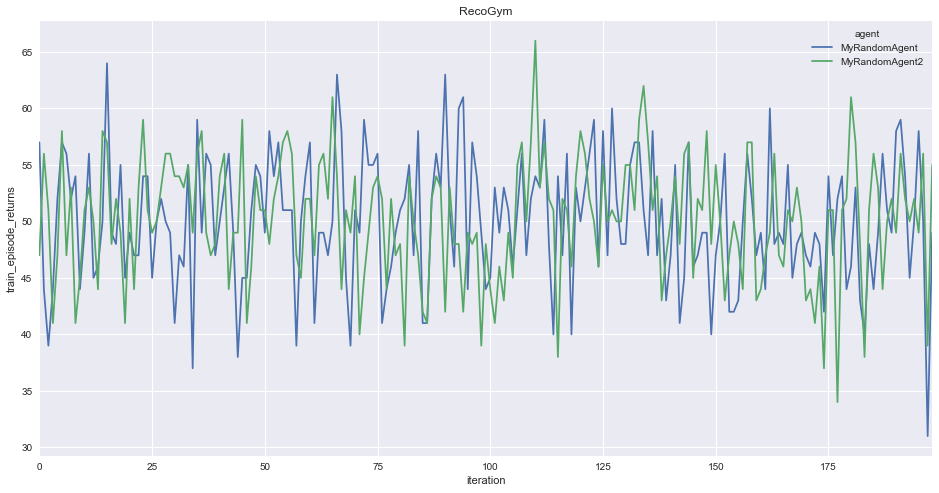

In [61]:

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(16,8))
sns.tsplot(data=experimental_data[GAME], time='iteration', unit='run_number',
           condition='agent', value='train_episode_returns', ax=ax)
plt.title(GAME)
plt.show()